# NEURAL NETWORKS
- 파이토치에서 ```torch.nn``` 패키지를 이용하여 인공신경망을 구현할 수 있음
- ```nn.module``` 은 레이어와 출력을 반환하는 ```forward(input)``` 메서드를 가짐

>예시로 **digit image 를 분류하는 신경망을 만들어 보겠음**
>1. 학습 가능한 파라미터로 이루어진 인공신경망 정의
>2. 학습 데이터셋에 대해 iterate
>3. 네트워크에 데이터 입력
>4. loss 계산
>5. 네트워크 파라미터에 gradient 를 역전파
>6. ```weight = weight - learning_rate * gradient``` 형식으로 각 파라미터를 업데이트

---
# 1. Define the network

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)    # Conv2d(input_channel, output_channel, kernel_size)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16*5*5, 120)   # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        print(x.size())
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)     # pooling window 가 정사각형이면 스칼라로 적어도 됨
        print(x.size())
        x = torch.flatten(x, 1)     # batch_size 를 제외하고 모든 차원을 flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- **forwawrd** 함수는 직접 정의해야 함
- **backward** 함수는 ```autograd``` 로 자동으로 정의됨

>**주의사항**
>- ```torch.nn``` 은 **미니배치 형식의 입력만 지원**함
>- single sample 은 지원하지 않음
>- 예를 들어 ```nn.Conv2d``` 는 오직 ```nSamples x nChannels x Height x Width``` 형태의 입력만 받음
>- 만약 single sample 을 사용해야 한다면 ```input.unsqueeze(0)``` 함수를 이용하여 미니 배치로 만들 수 있음

- **학습 가능한 파라미터** 는 ```net.parameters()``` 메서드로 불러올 수 있음

In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


- 테스트로 랜덤 32x32 이미지를 입력해보겠음
- MSNIT 데이터셋을 사용한다면 이미지 리사이즈 작업 필요

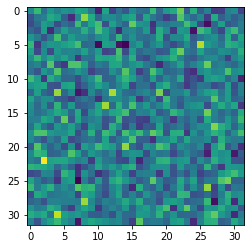

In [30]:
tmp = torch.randn(1, 1, 32, 32)
import matplotlib.pyplot as plt

plt.imshow(tmp.view(32, 32).numpy())

In [41]:
out = net(tmp)
print(out)

torch.Size([1, 6, 14, 14])
torch.Size([1, 16, 5, 5])
tensor([[-0.0337, -0.0243, -0.0568, -0.0504, -0.0541,  0.0672,  0.0552,  0.1926,
          0.0341, -0.1297]], grad_fn=<AddmmBackward>)


- 파라미터의 **gradient buffer** 를 초기화하고
- 역전파를 진행

In [13]:
net.zero_grad()
out.backward(torch.randn(1, 10))

---
## Recap
- ```torch.Tensor``` : autograd 연산을 지원하는 다차원 배열. 텐서에 대한 gradient 를 저장하기도 함
- ```nn.Module``` : 인공신경망 모듈. 파라미터를 캡슐화, 저장, 로드, GPU 옮기기 등을 편리하게 해줌
- ```nn.Parameter``` : 텐서의 한 종류. ```Module``` 의 특성으로 할당되면 자동으로 파라미터로 등록됨
- ```autograd.Function``` : autograd 연산의 **forward, backward** 를 정의함. 모든 ```Tensor``` 연산은 적어도 하나 이상의 ```Function``` 을 생성함.

---
# 2. Loss Function
- loss function 은 (모델의 출력, 정답값) 을 입력으로 받음
- 그리고 모델의 출력이 정답값과 얼마나 다른지 추정함

- 파이토치는 다양한 loss function 을 제공하지만 여기선 **mean-squared error** 를 계산하는 ```nn.MSELoss``` 를 사용해 보겠음

In [18]:
output = net(tmp)
target = torch.randn(10)
target = target.view(1, -1)   # 모델의 출력과 같은 차원으로 만드는 작업
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9966, grad_fn=<MseLossBackward>)


In [24]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

- 이런 방식으로 계속 역전파하여 결국 포함된 모든 연산에 사용된 파라미터들의 gradient 를 계산함

---
# 3. Backprop
- ```loss.backward()``` 를 호출하여 에러를 역전파
- 이때 **이미 존재하는 gradient 를 초기화하고 호출해야 함**. 안그러면 gradient 가 축적됨

In [25]:
net.zero_grad()

print(net.conv1.bias.grad)
loss.backward()
print(net.conv1.bias.grad)

tensor([0., 0., 0., 0., 0., 0.])
tensor([ 0.0093,  0.0006,  0.0096,  0.0110, -0.0082, -0.0072])


---
# 4. Update the weights
- 가장 간단한 SGD 로 파라미터를 업데이트하는 방식은 다음과 같음  
```weight = weight = learning_rate * gradient```

In [27]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

- 하지만 파라미터를 업데이트하는 방식은 SGD 말고도 매우 다양함
- **따라서 torch.optim 패키지를 이용하는 것이 더 간단함**

In [28]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()
output = net(tmp)
loss = criterion(output, target)
loss.backward()
optimizer.step()